# Friends Classification Text (xgB) - 0

This is classification of dialogue in FRIENDS TV Series.

<!-- https://stackoverflow.com/questions/61000500/tensorflow-keras-bert-multiclass-text-classification-accuracy -->

In [1]:
import pandas as pd
import re
import numpy as np
import time

import os
import pprint
import tensorflow as tf

import sys
sys.path.insert(1, '../../src/all_functions/')

from text_tools import *

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import joblib
from sklearn.model_selection import cross_validate
from sklearn import metrics

In [2]:
# help(drive.mount)

In [3]:
# PATH_DATA = 'gdrive/'
PATH_DATA = '../../data/'

## Importing Data

In [4]:
df_dlg_seen = pd.read_csv(PATH_DATA+'friends_seen_season_new.csv')
df_dlg_unseen = pd.read_csv(PATH_DATA+'friends_unseen_season_new.csv')

In [5]:
df_dlg_seen['text'] = df_dlg_seen['dialogue5']
df_dlg_unseen['text'] = df_dlg_unseen['dialogue5']

In [6]:
# df_dlg_unseen

In [7]:
data_train = df_dlg_seen[(df_dlg_seen.is_train == True)&(df_dlg_seen.label!=0)&(df_dlg_seen.len_dialogue5>0)][['text','label']]
data_train['label'] = data_train['label']-1
data_test = df_dlg_seen[(df_dlg_seen.is_train == False)&(df_dlg_seen.label!=0)&(df_dlg_seen.len_dialogue5>0)][['text','label']]
data_test['label'] = data_test['label']-1
data_unseen = df_dlg_unseen[(df_dlg_unseen.label!=0)&(df_dlg_unseen.len_dialogue5>0)][['text','label']]
data_unseen['label'] = data_unseen['label']-1

In [8]:
data_train.shape

(28949, 2)

In [9]:
data_test.shape

(9652, 2)

In [10]:
data_unseen.shape

(9268, 2)

In [11]:
XX = data_test.label.value_counts()
XX/XX.sum()

1    0.180377
0    0.178512
3    0.168255
2    0.165665
4    0.159656
5    0.147534
Name: label, dtype: float64

## Tokenizer - TFIDF

In [34]:
MAX_LEN = 100
EMBED_SIZE = 128

In [35]:
OH = OneHotEncoder()

In [36]:
data_train.head()

,text,label
0,there has nothing to tell he has just some i w...,2
2,all joey be nice so does he have a hump a hump...,3
4,just because i do not her to through what i we...,5
5,everybody relax this is not even a date it has...,2
6,sounds a date to me,3


In [37]:
data_test.head()

,text,label
1,on you are going out with the there has gotta ...,4
3,wait does he eat chalk,5
9,then i down and i realize there has a phone there,3
11,that has,3
14,all of a sudden the phone starts to ring now i...,3


In [38]:
df_dlg_unseen.head()

,eps,dialogue_ids,scenes_places,label_place,label_str,label,season,dialogue,dialogue5,len_dialogue5,is_null2,ids,text
0,0901,0,[rachel's room],2,rachel,1,9,joey. (he turns to face rachel on one knee w...,joey,1,False,49643,joey
1,0901,1,[rachel's room],2,rachel,1,9,(seeing the ring) oh my god. (pause) okay. (...,my god,2,False,49644,my god
2,0901,2,[rachel's room],2,rachel,1,9,so uh...i guess we should...make it official...,so i guess we should make it official huh,9,False,49645,so i guess we should make it official huh
3,0901,3,[rachel's room],2,joey,5,9,uh... look rach...(ross enters.) hey ross is...,rach ross is here it has my friend ross ross,10,False,49646,rach ross is here it has my friend ross ross
4,0901,4,[rachel's room],2,ross,2,9,hey joey. (to rachel) hey you.,joey you,2,False,49647,joey you


In [39]:
corpus = data_train['text'].tolist()+data_test['text'].tolist()
vectorizer = TfidfVectorizer(min_df = 0.05, max_features = MAX_LEN)
vectorizer.fit(corpus)

TfidfVectorizer(max_features=100, min_df=0.05)

In [40]:
def get_input(df):
    txt = df['text']
    X = vectorizer.transform(txt)
    label = df['label']
    return X.toarray(),label.values

In [41]:
# for txt,label in data_train.values:
#     text_encode = encode(txt)
#     text_encode = set_fix_length(text_encode,max_len = MAX_LEN)
#     X_train.append(text_encode)
#     label_train.append(label)
    
X_train,label_train = get_input(pd.concat([data_train,data_test]))
X_unseen,label_unseen = get_input(data_unseen)

In [42]:
OH.fit(label_train.reshape(len(label_train),-1))

OneHotEncoder()

In [43]:
y_train = OH.transform(label_train.reshape(len(label_train),-1)).toarray()
# y_test = OH.transform(label_test.reshape(len(label_test),-1)).toarray()
y_unseen = OH.transform(label_unseen.reshape(len(label_unseen),-1)).toarray()

In [44]:
label_train

array([2, 3, 5, ..., 0, 4, 0])

## Training Model

In [45]:
def xgb_evaluate(max_depth,learning_rate,n_estimators,
                 gamma, reg_alpha,reg_lambda,X=X_train,y=label_train):

    md= int(max_depth)
    lr= max(learning_rate,0)
    ne= int(n_estimators)
    gamma= max(gamma, 0) # 0
    ra= max(reg_alpha, 0) # 0
    rl= max(reg_lambda, 0) # 1
    see= 123
    
    xgB=XGBClassifier(max_depth=md,learning_rate=lr,
                 n_estimators=ne,gamma=gamma,reg_alpha=ra,
                 reg_lambda=rl,seed=see, 
                 nthread=2,num_classes=6)
    cv_results = cross_validate(xgB, X, y, cv=5, scoring='f1_macro', n_jobs= 2)
    return cv_results['test_score'].mean()

In [50]:
xgbBO = BayesianOptimization(xgb_evaluate, 
                {'max_depth': (10,20),'learning_rate': (0.25, 0.5),
                    'n_estimators': (13,20),'gamma': (0.05, 1),'reg_alpha': (1.5, 3),
                    'reg_lambda': (1.5, 3)})

In [51]:
xgbBO.maximize(init_points=8, n_iter=5)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
|  1        |  0.1828   |  0.9007   |  0.2617   |  17.29    |  15.19    |  1.521    |  1.713    |
|  2        |  0.1847   |  0.6286   |  0.442    |  15.39    |  14.82    |  1.845    |  1.965    |
|  3        |  0.1829   |  0.3867   |  0.4183   |  13.97    |  14.34    |  2.367    |  2.437    |
|  4        |  0.1802   |  0.4325   |  0.2996   |  11.26    |  14.76    |  2.716    |  2.151    |
|  5        |  0.1812   |  0.3738   |  0.4914   |  11.1     |  14.95    |  2.36     |  1.921    |
|  6        |  0.1804   |  0.7742   |  0.2562   |  12.79    |  18.07    |  2.07     |  2.555    |
|  7        |  0.1814   |  0.4398   |  0.3565   |  14.9     |  13.86    |  1.537    |  1.547    |
|  8        |  0.1823   |  0.4208   |  0.4411   |  15.17    |  18.57    |  1.917    |  2.38     |
|  9        |  0.184

In [52]:
# 1
# |  18       |  0.2054   |  1.885    |  0.1672   |  14.55    |  10.49    |  2.814    |  0.9857   |

# |  12       |  0.1845   |  0.1      |  0.35     |  13.89    |  17.0     |  2.0      |  2.0      |
# |  12       |  0.1856   |  0.7185   |  0.4815   |  15.04    |  15.25    |  1.737    |  1.63     |

In [53]:
par = xgbBO.max['params']
par

{'gamma': 0.7184807025377496,
 'learning_rate': 0.48145204251945456,
 'max_depth': 15.038466767153695,
 'n_estimators': 15.246661277804376,
 'reg_alpha': 1.7365340764778867,
 'reg_lambda': 1.6297941249050243}

In [54]:
par['max_depth'] = int(par['max_depth'])
par['n_estimators'] = int(par['n_estimators'])

In [55]:
xgB0=XGBClassifier(**par)
xgB0.fit(X_train,label_train)

/Users/alamhanz/anaconda/envs/p37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.7184807025377496,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.48145204251945456, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=15, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0,
              reg_alpha=1.7365340764778867, reg_lambda=1.6297941249050243,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

## Testing

In [56]:
data_unseen

,text,label
0,joey,0
1,my god,0
2,so i guess we should make it official huh,0
3,rach ross is here it has my friend ross ross,4
4,joey you,1
...,...,...
11842,it has be,3
11843,do you guys have to to the new house away or d...,0
11844,we some time,2
11845,should we some coffee,0


In [57]:
y_pred_label = xgB0.predict(X_unseen)
# y_pred_label = np.argmax(y_pred,axis = 1)
y_true_label = data_unseen['label'].values

              precision    recall  f1-score   support

           0       0.18      0.38      0.25      1599
           1       0.19      0.15      0.17      1678
           2       0.20      0.20      0.20      1507
           3       0.20      0.17      0.18      1551
           4       0.18      0.13      0.15      1513
           5       0.16      0.09      0.11      1420

    accuracy                           0.19      9268
   macro avg       0.19      0.18      0.18      9268
weighted avg       0.19      0.19      0.18      9268



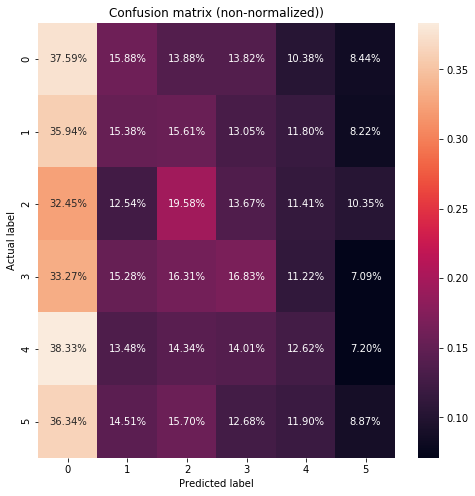

In [58]:
report = classification_report(y_true_label, y_pred_label)
print(report)


def plot_cm(labels, predictions, p=0.5):
#     cm = confusion_matrix(labels, predictions)
#     plt.figure(figsize=(5, 5))
#     sns.heatmap(cm, annot=True, fmt="d")
    cm = confusion_matrix(labels, predictions)
    cm = (cm.transpose()/cm.sum(axis = 1)).transpose()
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2%")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_true_label, y_pred_label)

              precision    recall  f1-score   support

           0       0.24      0.28      0.26      1356
           1       0.20      0.29      0.23      1483
           2       0.20      0.25      0.22      1340
           3       0.21      0.19      0.20      1382
           4       0.23      0.15      0.18      1347
           5       0.20      0.10      0.13      1251

    accuracy                           0.21      8159
   macro avg       0.21      0.21      0.20      8159
weighted avg       0.21      0.21      0.21      8159



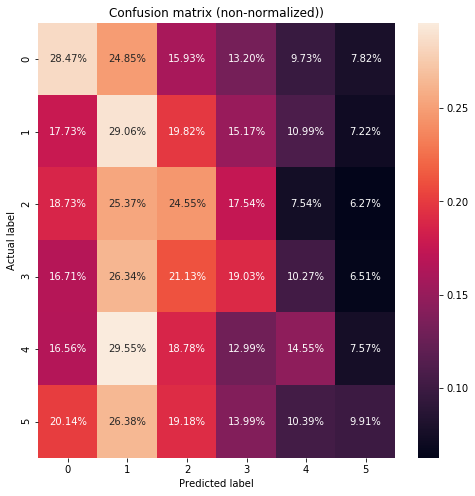

In [53]:
report = classification_report(y_true_label, y_pred_label)
print(report)


def plot_cm(labels, predictions, p=0.5):
#     cm = confusion_matrix(labels, predictions)
#     plt.figure(figsize=(5, 5))
#     sns.heatmap(cm, annot=True, fmt="d")
    cm = confusion_matrix(labels, predictions)
    cm = (cm.transpose()/cm.sum(axis = 1)).transpose()
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2%")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_true_label, y_pred_label)